In [1]:
import os
import cv2
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [3]:
TARGET_SIZE = (64, 64)

def load_data(directory):
    X, y = [], []

    for label in os.listdir(directory):
        class_dir = os.path.join(directory, label)
        if not os.path.isdir(class_dir):
            continue

        for file in os.listdir(class_dir):
            img_path = os.path.join(class_dir, file)
            img = cv2.imread(img_path)

            if img is None:
                continue

            img = cv2.resize(img, TARGET_SIZE)
            vector = img.flatten()

            X.append(vector)
            y.append(label)

    return np.array(X), np.array(y)


In [4]:
DATA_DIR = r"F:\WIDS-5.0\data\plantvillage dataset\color"


In [5]:
X, y = load_data(DATA_DIR)

X = X.astype('float32') / 255.0 

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [6]:
print(X.shape)
print(X[0].shape)
print(len(np.unique(y)))
print(np.unique(y)[:])


(54305, 12288)
(12288,)
38
['Apple___Apple_scab' 'Apple___Black_rot' 'Apple___Cedar_apple_rust'
 'Apple___healthy' 'Blueberry___healthy'
 'Cherry_(including_sour)___Powdery_mildew'
 'Cherry_(including_sour)___healthy'
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot'
 'Corn_(maize)___Common_rust_' 'Corn_(maize)___Northern_Leaf_Blight'
 'Corn_(maize)___healthy' 'Grape___Black_rot'
 'Grape___Esca_(Black_Measles)'
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)' 'Grape___healthy'
 'Orange___Haunglongbing_(Citrus_greening)' 'Peach___Bacterial_spot'
 'Peach___healthy' 'Pepper,_bell___Bacterial_spot'
 'Pepper,_bell___healthy' 'Potato___Early_blight' 'Potato___Late_blight'
 'Potato___healthy' 'Raspberry___healthy' 'Soybean___healthy'
 'Squash___Powdery_mildew' 'Strawberry___Leaf_scorch'
 'Strawberry___healthy' 'Tomato___Bacterial_spot' 'Tomato___Early_blight'
 'Tomato___Late_blight' 'Tomato___Leaf_Mold' 'Tomato___Septoria_leaf_spot'
 'Tomato___Spider_mites Two-spotted_spider_mite' 'Tomato___

## Why `stratify=y` and `random_state=42` are Used in `train_test_split`

### `stratify=y`
- Ensures that **class proportions in train and test sets match the original dataset**
- Prevents **minority classes from being underrepresented or missing** in the test set
- Makes baseline metrics (especially Dummy Classifier accuracy) **statistically meaningful**
- Critical for **imbalanced datasets** like PlantVillage

Formally, for any class \( c \):

$\mathbb{P}(Y_{\text{train}} = c) \approx \mathbb{P}(Y_{\text{test}} = c)$

Without stratification:
- Accuracy becomes misleading
- Confusion matrices lose validity
- Baseline comparisons break

---

### `random_state=42`
- Fixes the random seed for reproducible splits
- Ensures **consistent train/test partitions across runs**
- Allows fair comparison between models (Dummy vs SVM vs CNN)

There is **no special meaning to 42** — any fixed integer works.  
What matters is **reproducibility**, not the value itself.

---

### Summary
- `stratify=y` → preserves class balance and evaluation validity  
- `random_state=42` → guarantees reproducible and comparable experiments


In [7]:
dummy_model = DummyClassifier(strategy="most_frequent")
dummy_model.fit(X_train, y_train)

y_pred_dummy = dummy_model.predict(X_test)

dummy_acc = accuracy_score(y_test, y_pred_dummy)
dummy_cm = confusion_matrix(y_test, y_pred_dummy)

print(f"Dummy Baseline Accuracy: {dummy_acc:.4f}")
print(dummy_cm)


Dummy Baseline Accuracy: 0.1015
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


The Dummy Baseline accuracy equals the proportion of the largest class in the dataset, since the model always predicts the most frequent label.  
An accuracy of ~10% indicates a multi-class, reasonably balanced dataset, confirming that the data loading and splitting are correct.


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [16]:
from sklearn.ensemble import RandomForestClassifier

# We use n_jobs=-1 to speed up training by using all CPU cores.
my_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, class_weight='balanced')

In [17]:
X_train

array([[0.47843137, 0.4745098 , 0.5137255 , ..., 0.59607846, 0.5882353 ,
        0.6117647 ],
       [0.5921569 , 0.5137255 , 0.5647059 , ..., 0.6       , 0.57254905,
        0.6313726 ],
       [0.6509804 , 0.58431375, 0.61960787, ..., 0.42745098, 0.5294118 ,
        0.49803922],
       ...,
       [0.67058825, 0.654902  , 0.7019608 , ..., 0.49803922, 0.49411765,
        0.5568628 ],
       [0.3764706 , 0.3882353 , 0.39215687, ..., 0.31764707, 0.32941177,
        0.32156864],
       [0.64705884, 0.6509804 , 0.6901961 , ..., 0.6431373 , 0.6509804 ,
        0.69411767]], dtype=float32)

In [18]:
my_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [19]:
y_pred = my_model.predict(X_test)

In [22]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Shallow Baseline Accuracy: {accuracy:.4f}")

# Generate Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Shallow Baseline Accuracy: 0.6824
Confusion Matrix:
[[ 56   2   0 ...   6   1   6]
 [  0  84   0 ...  12   0   1]
 [  0   0   2 ...  20   0   1]
 ...
 [  0   0   0 ... 930   0   0]
 [  0   0   0 ...  17  13   1]
 [  0   0   0 ...  18   0 256]]


In [23]:
print(classification_report(y_test, y_pred, zero_division=0))

                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.84      0.44      0.58       126
                                 Apple___Black_rot       0.75      0.68      0.71       124
                          Apple___Cedar_apple_rust       1.00      0.04      0.07        55
                                   Apple___healthy       0.74      0.61      0.67       329
                               Blueberry___healthy       0.78      0.80      0.79       300
          Cherry_(including_sour)___Powdery_mildew       0.71      0.51      0.60       210
                 Cherry_(including_sour)___healthy       0.91      0.58      0.71       171
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.44      0.14      0.21       103
                       Corn_(maize)___Common_rust_       0.98      0.99      0.98       239
               Corn_(maize)___Northern_Leaf_Blight       0.54      0.72      0.

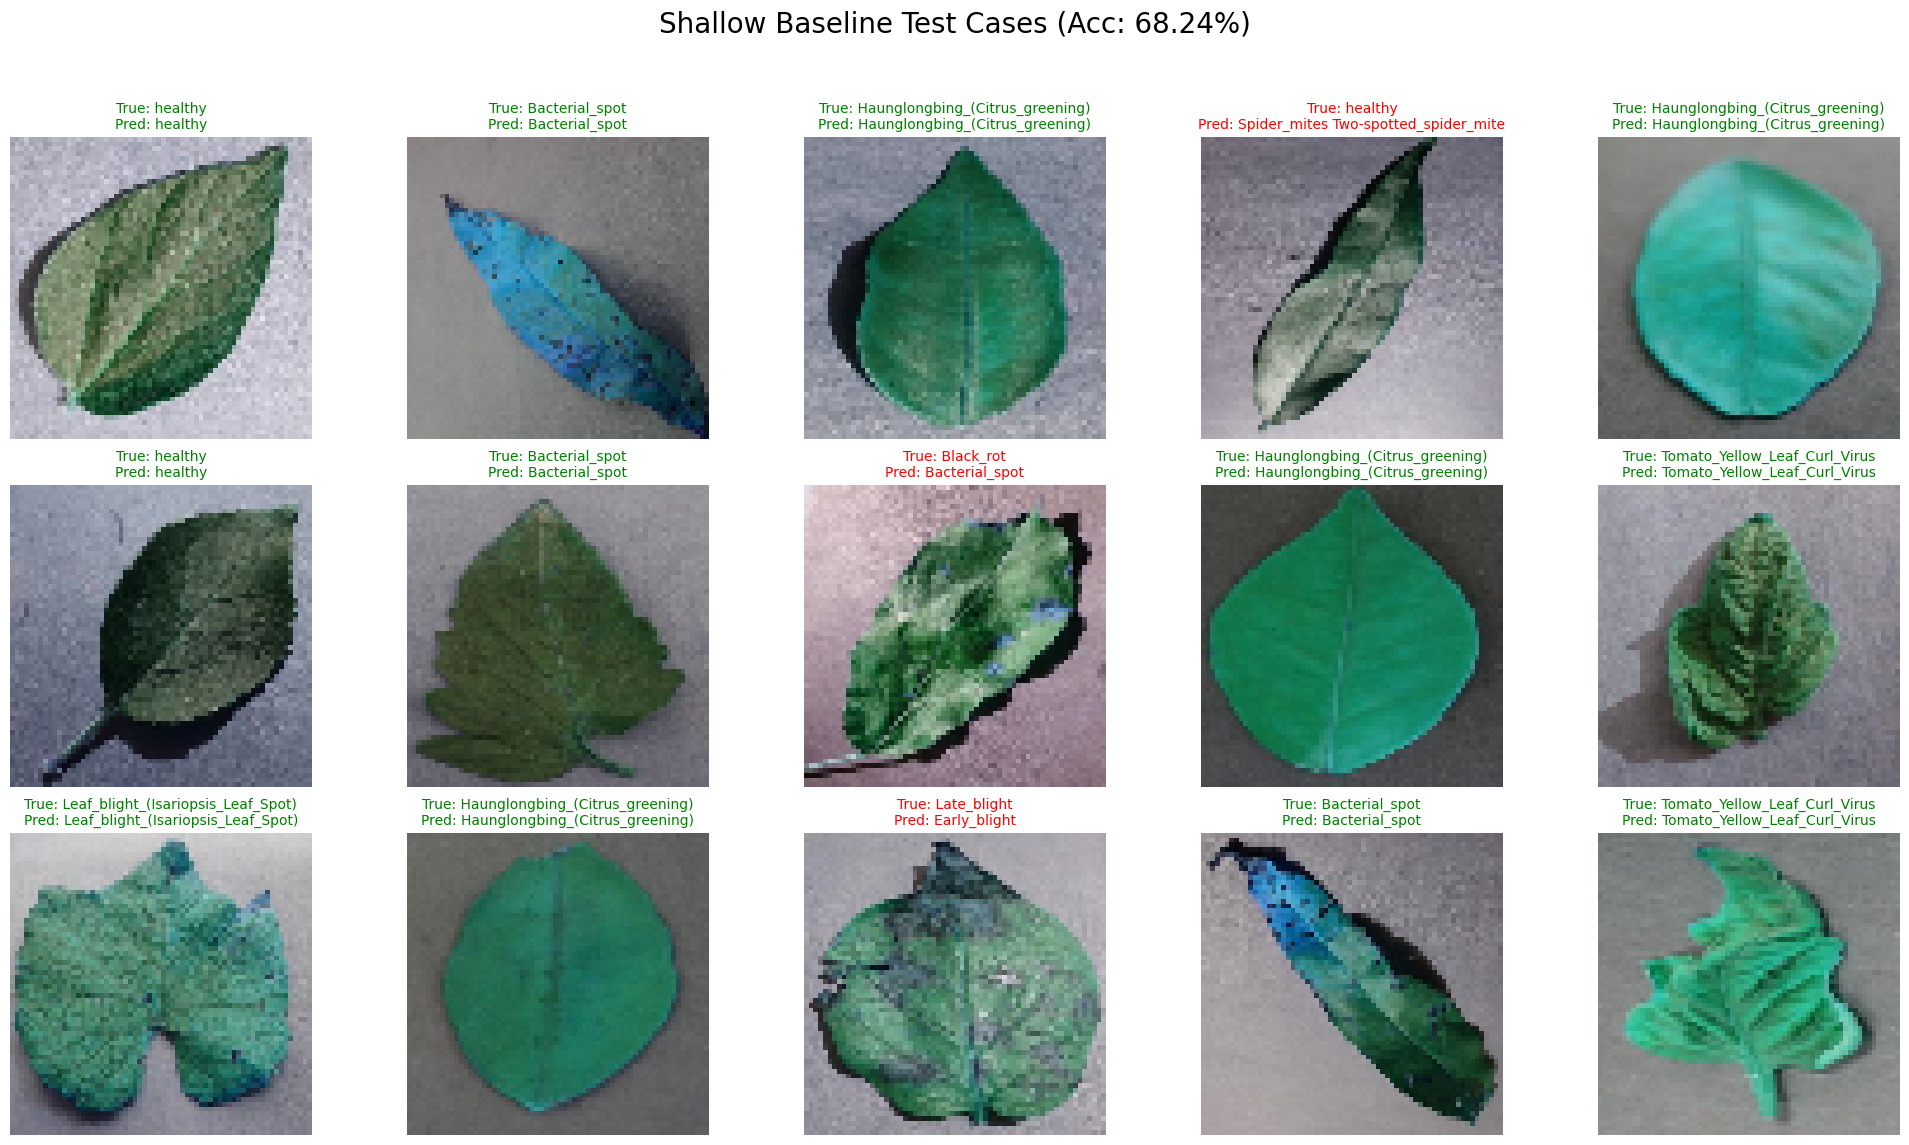

In [26]:
import matplotlib.pyplot as plt

# 1. Select 15 random indices from the test set
indices = np.random.choice(len(y_test), 15, replace=False)

fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle(f"Shallow Baseline Test Cases (Acc: {accuracy_score(y_test, y_pred):.2%})", fontsize=20)

for i, idx in enumerate(indices):
    ax = axes[i // 5, i % 5]
    # Reshape the flattened vector back to 64x64x3 for display
    img = X_test[idx].reshape(64, 64, 3) 
    
    true_label = y_test[idx].split('___')[-1] # Simplify name for display
    pred_label = y_pred[idx].split('___')[-1]
    
    is_correct = true_label == pred_label
    color = "green" if is_correct else "red"
    
    ax.imshow(img)
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    ax.axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()